<a href="https://colab.research.google.com/github/CamiD11/caraza-harter-com/blob/master/Copy_of_ME310_Class_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning in FFF

### Developed by Paul E. V. Oehlmann, Gerardo A. Mazzei Capote, and Zijie Liu.

Last revision: October 2021 columns: Uz, F file name: ME310-data.csv

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<div class="alert alert-block alert-info">
<b></b> The code below is designed to give you a simple introduction to Machine Learning (ML) applied to polymer engineering problems. The snippet of code below simply imports the necessary Python libraries so the code runs properly. Be sure to run this first and foremost. This particular application of ML utilizes the TensorFlow framework applied through keras.</div>

In [87]:
from __future__ import absolute_import, division, print_function

import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.2


<div class="alert alert-block alert-info">
<b></b>The snippet of code below simply loads the data and formats it in a way the software can interpret it. Make sure you name the data under the csv file format and save it under the same directory as this Jupyter Notebook for the code to properly work! For the purposes of this class we will be using the following notation:

* $U_{sz}$ is the measured filament velocity.
* $F_z$ is the measured force applied by the filament.</div>

In [88]:
column_names = ['USZ','F']
raw_dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/0.8_Cleaned_Data.csv', names=column_names, na_values="?", comment='\t', sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()
USZ = dataset.iloc[:, 0].values
print(USZ[0:10])
print(dataset)

[1.16807874 1.19078997 1.35777164 1.061898   1.28479697 1.22028276
 1.17144844 1.19320318 1.28904001 1.04228943]
           USZ            F
0     1.168079   615.711253
1     1.190790   594.479830
2     1.357772   615.711253
3     1.061898   594.479830
4     1.284797   615.711253
...        ...          ...
3413  3.749882  1019.108280
3414  3.727945  1019.108280
3415  3.735721  1040.339703
3416  3.453037  1040.339703
3417  3.430995  1019.108280

[3418 rows x 2 columns]


<div class="alert alert-block alert-info">
<b></b> The code below is designed to drop missing values in each column.</div>

In [89]:
dataset.isna().sum()
dataset = dataset.dropna()
dataset.tail()

,USZ,F
3413,3.749882,1019.108280
3414,3.727945,1019.108280
3415,3.735721,1040.339703
3416,3.453037,1040.339703
3417,3.430995,1019.108280


<div class="alert alert-block alert-info">
<b></b> Split the data into train and test. We will use the test set in the final evaluation of our model. </div>

In [90]:
train_dataset = dataset.sample(frac=0.8, random_state=5)
test_dataset = dataset.drop(train_dataset.index)

<div class="alert alert-block alert-info">
<b></b>Inspect the data. First, have a quick look at the joint distribution of a few pairs of colums from the training set. Then also look at the overall statistics.</div>

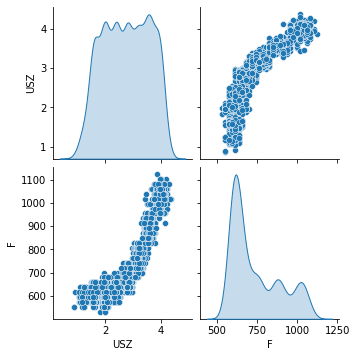

In [91]:
sns.pairplot(train_dataset[["USZ", "F"]], diag_kind="kde")
plt.show()

In [92]:
train_stats = train_dataset.describe() #for calculating some statistical data like percentile, mean and std of the numerical values of the Series or DataFrame
train_stats.pop("F") 
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
USZ,2734.0,2.752221,0.823008,0.87345,2.020079,2.783208,3.513959,4.378702


<div class="alert alert-block alert-info">
<b></b> Split features from labels.
</div>

In [93]:
train_labels = train_dataset.pop('F')
test_labels = test_dataset.pop('F')
test_labels

5        615.711253
14       615.711253
16       615.711253
17       615.711253
19       615.711253
           ...     
3351     997.876858
3363     997.876858
3366     997.876858
3379    1061.571125
3415    1040.339703
Name: F, Length: 684, dtype: float64

<div class="alert alert-block alert-info">
<b></b>Normalize the data. Look again at the train_stats block above and note how different the ranges of each feature are. It is good practice to normalize features that use different scales and ranges. Without feature normalization makes training more difficult and the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.
</div>

In [94]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

<div class="alert alert-block alert-info">
<b></b> Build the model: Here, we’ll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we’ll create a second model, later on.
</div>

In [95]:
def build_model():
    model = keras.Sequential([
        layers.Dense(50, activation=tf.nn.sigmoid, input_shape=[
                     len(train_dataset.keys())]),
        layers.Dense(50, activation=tf.nn.sigmoid),
        layers.Dense(1)
  ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999,epsilon=1e-07, amsgrad=False, name="Adam")

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


model = build_model()

<div class="alert alert-block alert-info">
<b></b> Inspect the model: Use the .summary method to print a simple description of the model. And try out the model. Take a batch of 10 examples from the training data and call model.predict on it.
</div>

In [96]:
print(model.summary())
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
print('example batch')
print(example_batch)
print('example result')
print(example_result)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 50)                100       
                                                                 
 dense_31 (Dense)            (None, 50)                2550      
                                                                 
 dense_32 (Dense)            (None, 1)                 51        
                                                                 
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________
None
1/1 [==============================] - 0s 61ms/step
example batch
           USZ
163  -1.375486
2631  1.011012
2193  0.696908
2804  1.006695
2128  0.452830
2984  1.366163
544  -1.709703
3003  1.501782
1834 -0.056906
1056 -0.469143
example result
[[1.0205467]
 [1.026271 ]
 [1.0253414]
 [1.026258 ]
 [1.0246485]

<div class="alert alert-block alert-info">
<b></b>$Train$ $the$ $model$: Train the model for 500 epochs, and record the training and validation accuracy in the history object.</div>

In [97]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')


EPOCHS = 500

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[PrintDot()])
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
495,1188.365112,26.404760,1188.365112,1425.953857,28.689077,1425.953857,495
496,1180.993286,25.914808,1180.993286,1304.989258,27.480238,1304.989258,496
497,1221.930054,26.510658,1221.930054,1269.944214,27.560673,1269.944214,497
498,1108.349487,25.677223,1108.349487,1213.416626,26.943810,1213.416626,498
499,1092.436035,25.461399,1092.436035,1322.383545,27.389700,1322.383545,499


<div class="alert alert-block alert-info">
<b></b> Then we can visualize the model's training progress using the stats stored in the history object.
</div>

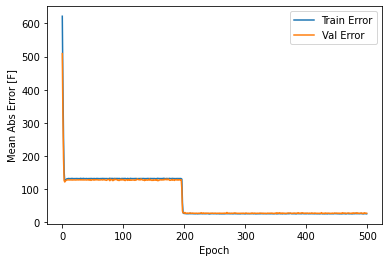

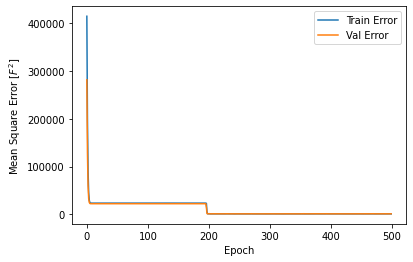

In [98]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [F]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
             label='Val Error')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$F^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
             label='Val Error')
    plt.legend()
    plt.show()
plot_history(history)


<div class="alert alert-block alert-info">
<b></b> Above graph shows little improvement, or even degradation in the validation error after about 100 epochs. We hope to automatically stop training when the validation score doesn’t improve. We’ll use an EarlyStopping callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.
</div>


...................................................

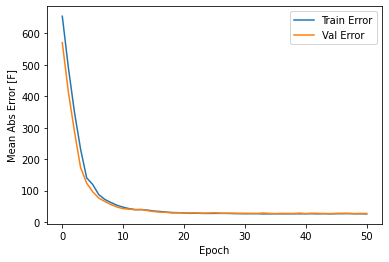

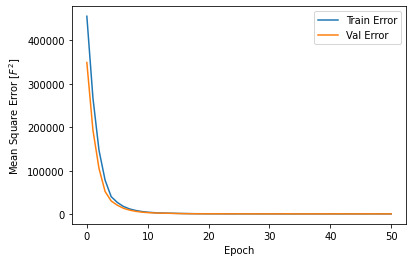

In [99]:
model = build_model()
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Validate
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

<div class="alert alert-block alert-info">
<b></b>Let’s see how well the model generalizes by using the test set, which we did not use when training the model. This tells us how well we can expect the model to predict when we use it in the real world.
</div>

In [100]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} F".format(mae))

Testing set Mean Abs Error: 25.45 F


<div class="alert alert-block alert-info">
<b></b> Make predictions: Finally, predict F values using data in the testing set
</div>

22/22 [==============================] - 0s 1ms/step
5        615.711253
14       615.711253
16       615.711253
17       615.711253
19       615.711253
           ...     
3351     997.876858
3363     997.876858
3366     997.876858
3379    1061.571125
3415    1040.339703
Name: F, Length: 684, dtype: float64 [ 607.5234   607.4725   607.51776  607.5309   607.5226   607.6279
  607.5177   607.4954   607.5215   607.50195  607.54706  607.4265
  607.55273  607.50226  607.49695  607.5199   607.5292   607.5373
  607.5259   607.7817   607.7165   607.799    607.7943   607.70465
  607.9489   607.8571   607.9214   607.6128   607.7238   607.84357
  607.7831   607.7585   607.76984  607.7623   608.00824  607.8936
  607.76465  607.7606   607.6416   607.811    607.8652   607.7461
  607.6558   607.8671   607.6704   607.82043  607.7696   607.8346
  607.73566  607.80664  607.8556   607.78674  607.4345   607.6932
  607.8637   607.7674   607.79236  607.6622   607.80035  607.7199
  607.8711   607.7985   607.

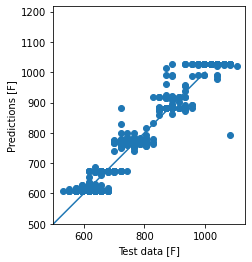

In [101]:
test_predictions = model.predict(normed_test_data).flatten()
print(test_labels, test_predictions)
plt.scatter(test_labels, test_predictions)
plt.xlim([600, 1000])
plt.ylim([600, 1000])
plt.xlabel('Test data [F]')
plt.ylabel('Predictions [F]')
plt.axis('equal')
plt.axis('square')
plt.xlim([500, plt.xlim()[1]])
plt.ylim([500, plt.ylim()[1]])
_ = plt.plot([500, 1000], [500, 1000])
plt.show()

<div class="alert alert-block alert-info">
<b></b> It looks like our model predicts reasonably well. Let’s take a look at the error distribution.
</div>

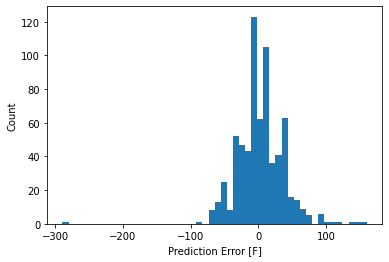

In [102]:
error = test_predictions - test_labels
plt.hist(error, bins=50)
plt.xlabel("Prediction Error [F]")
_ = plt.ylabel("Count")
plt.show()

Done! Congratulation!!!